# Inference on the GPU with RAPIDS

<img src="https://rapids.ai/assets/images/RAPIDS-logo-purple.png" width="400">

This notebook can be easily run inside [Saturn Cloud](https://saturncloud.io/), where all the depdencies are available in an image. 

1. Sign up for a free account on [Saturn Cloud Hosted](https://accounts.community.saturnenterprise.io/auth/signup)
1. Create a new project: Under "Quick Start Projects", click "Blank GPU project"
1. Edit the project, then under "Advanced Settings" add the following:
    ```bash
    pip install category-encoders seaborn
    ````
1. Open up Jupyter Lab: Click the green play button to start the server, then when its up click "Jupyter Lab"
1. Upload this notebook (or clone from this repo)

In [1]:
from typing import List, Union, Dict
import numpy as np
import json

import cudf
import pandas as pd

from cuml.preprocessing.TargetEncoder import TargetEncoder
from category_encoders.target_encoder import TargetEncoder as TargetEncoderSikit


from cuml.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifierScikit

def process_target(df):
    df = df[df.fare_amount > 0]
    df["tip_fraction"] = df.tip_amount / df.fare_amount
    df['target'] = (df["tip_fraction"] > 0.2).astype(int)
    return df.reset_index()

In [2]:
taxi = cudf.read_csv(
    "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
)

In [3]:
print(f"Num rows: {len(taxi)}, Size: {round(taxi.memory_usage(deep=True).sum() / 1e9, 2)} GB")

Num rows: 7667792, Size: 1.08 GB


In [4]:
subsample = process_target(taxi)
# subample = subsample.sample(1000).reset_index(drop=True)

In [5]:
class MyModel:
    def __init__(self, model:RandomForestClassifier, cat_feature: str, params:Dict, encoder):
        self.cat_feature = cat_feature
        self.model = model(**params)
        self.params = None
        self.target_encoder = encoder
        self.features = None
        
    def generate_date_feats(self, X: cudf.DataFrame) -> cudf.DataFrame:
        X["pickup_weekday"] = X.tpep_pickup_datetime.dt.weekday
        X["pickup_hour"] = X.tpep_pickup_datetime.dt.hour
        X["pickup_week_hour"] = (X.pickup_weekday * 24) + X.pickup_hour
        X["pickup_minute"] = X.tpep_pickup_datetime.dt.minute
        return X
    
    def fit(self, X:Union[pd.DataFrame, cudf.DataFrame], y:np.array, scikit=False):
        X = self.generate_date_feats(X)
        if scikit:
            self.target_encoder.fit(X, y)
        else:
            self.target_encoder.fit(X[self.cat_feature], y)
        
        if scikit:
            X = self.target_encoder.transform(X)
        else:
            X[self.cat_feature] = self.target_encoder.transform(X[self.cat_feature])
        X = X.select_dtypes(include=['float64', 'int64', 'int32', 'int16'])
        self.features = X.columns
        X = X[self.features].astype('float32')
        self.model.fit(X, y)
    
    def predict(self, X, scikit=False):
        X = self.generate_date_feats(X)
        if scikit:
            X = self.target_encoder.transform(X)
        else:
            X[self.cat_feature] = self.target_encoder.transform(X[self.cat_feature])
        X = X[self.features].astype('float32')
        return self.model.predict_proba(X)

In [6]:
params = {'n_estimators': 300,
          'max_depth': 10,
          'n_streams':4}

features = [
    "passenger_count",
    "PULocationID",
    "DOLocationID",
    "tpep_pickup_datetime"
]

model_cuml = MyModel(model=RandomForestClassifier, cat_feature=['PULocationID', 'DOLocationID'], params=params, encoder=TargetEncoder())
model_cuml.fit(subsample[features], subsample.target.values)

In [7]:
params = {'n_estimators': 300,
          'max_depth': 10,
          'n_jobs':-1}
model_scikit = MyModel(model=RandomForestClassifierScikit, cat_feature=['PULocationID', 'DOLocationID'], params=params, encoder=TargetEncoderSikit(cols=['PULocationID', 'DOLocationID']))
model_scikit.fit(subsample[features].to_pandas(), np.array(subsample.target.values.tolist()), scikit=True)

In [8]:
import time
def make_multiple_predictions_rapids(model, json_array):
    latencies = []
    for obj in json_array:
        then = time.time()
        data = cudf.DataFrame(json.loads(obj))
        data['tpep_pickup_datetime'] = cudf.to_datetime(data['tpep_pickup_datetime'])
        model.predict(data)
        latencies.append(time.time() - then)
    return latencies


def make_multiple_predictions_scikit(model, json_array):
    latencies = []
    for obj in json_array:
        then = time.time()
        data = pd.DataFrame(json.loads(obj), index=[0])
        data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
        model.predict(data, scikit=True)
        latencies.append(time.time() - then)
    return latencies

In [9]:
samples = subsample[features].sample(200).to_pandas()
samples['tpep_pickup_datetime'] = samples['tpep_pickup_datetime'].astype('str')
samples = samples.to_dict(orient='records')
samples = [json.dumps(i) for i in samples]

In [10]:
rapids_predictions = make_multiple_predictions_rapids(model_cuml, samples)

In [11]:
scikit_predictions = make_multiple_predictions_scikit(model_scikit, samples)

In [12]:
scikit_latencies = pd.DataFrame({'method': 'scikit-learn', 'latency': scikit_predictions})
rapids_gpu_latencies = pd.DataFrame({'method': 'rapids', 'latency': rapids_predictions})
combined = pd.concat([scikit_latencies, rapids_gpu_latencies])
combined['latency'] = combined['latency'] * 1000

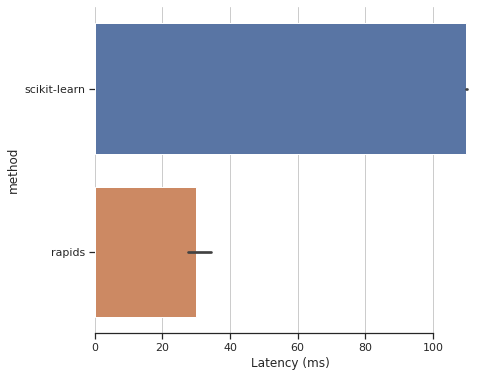

In [13]:
# create plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
# sns.boxplot(x="latency", y="method", data=combined,
#             whis=[0, 0.01], width=.6, palette="vlag")

sns.barplot(x='latency', y='method', data=combined)

# Add in points to show each observation
# sns.stripplot(x="latency", y="method", data=combined,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="Latency (ms)")
sns.despine(trim=True, left=True)